In [134]:
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np
import os
from skimage.metrics import structural_similarity as ssim
from cv2 import dnn_superres
from google.colab.patches import cv2_imshow 

from skimage import img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr

import pandas as pd

import time

In [135]:
listTechic = list()
listSSI = list()
listMSE = list()
listPSNR = list()
listAbsoluteErroMSE = list()
listAbsoluteErroSSI = list()
timeExecution = list()
listTamImg = list()
listDistnce = list()

In [136]:
def metricsCalculator(imgA,imgB):
    shapeImageACols,shapeImageALine, channelsA = imgA.shape
    shapeImageBCols,shapeImageBLine, channelsB = imgB.shape

    if (shapeImageACols,shapeImageALine) != (shapeImageBCols,shapeImageBLine):
        imgA = cv2.resize(imgA, (shapeImageBLine,shapeImageBCols), interpolation = cv2.INTER_AREA)
        shapeImageACols,shapeImageALine, channelsA = imgA.shape


    imgAfloat = img_as_float(imgA)
    imgBfloat = img_as_float(imgB)

    ssim_imgs = ssim(imgAfloat, imgBfloat, data_range=imgAfloat.max() - imgBfloat.min(),channel_axis=channelsA-1)
    mse_imgs = mse(imgAfloat, imgBfloat)
    psnr_imgs = psnr(imgAfloat,imgBfloat)
    return (ssim_imgs, mse_imgs, psnr_imgs)

In [137]:
def meanMetrics(imgA, imgB):

    a1,b1,c1 = metricsCalculator(imgA, imgB)
    a2,b2,c2 = metricsCalculator(imgB, imgA)
    # 1 0
    return ((a1+a2)/2,(b1+b2)/2,(c1+c2)/2)

In [138]:
def erroAbsolute(valueReal, valueObtido):
    return (abs(valueReal - valueObtido) )

In [139]:
def porcent(a,b):
    a = a+1
    b = b+1

    x = ((100 * b)/a) - 100

    return x

In [140]:
def analiseImgs(imgA, imgB):

    global listSSI
    global listMSE
    global listPSNR
    global listAbsoluteErroMSE
    global listAbsoluteErroSSI
    global listDistnce

    ssiResul,mseResul, psnrResul = meanMetrics(imgA, imgB)

    listSSI.append(ssiResul)
    listMSE.append(mseResul)
    listPSNR.append(psnrResul)


    listAbsoluteErroMSE.append(erroAbsolute(0,mseResul))
    listAbsoluteErroSSI.append(erroAbsolute(1,ssiResul))
    listDistnce.append(porcent(0,erroAbsolute(1,ssiResul)))
    

In [141]:
def tableCreate():
    global listTechic
    global listSSI
    global listMSE
    global listPSNR
    global listAbsoluteErroMSE
    global listAbsoluteErroSSI
    global timeExecution
    global listTamImg
    global listDistnce

    d = {'TechniqueName': listTechic, "MSE": listMSE, 'SSI': listSSI,"SSI Abs Error": listAbsoluteErroSSI , 
    "Distance Abs error at zero": listDistnce,"PSNR": listPSNR,"TamImg": listTamImg ,"TExecutin": timeExecution}
    df = pd.DataFrame(data=d)

    return df

In [142]:
def init_super(model, base_path='models'):
    
    # Define global variable
    global sr, model_name, model_scale
    
    # Create an SR object
    sr = dnn_superres.DnnSuperResImpl_create()
    
    # Define model path
    model_path = os.path.join(base_path , model +".pb")
    
    # Extract model name from model path
    model_name = model.split('_')[0].lower()
    
    # Extract model scale from model path
    model_scale = int(model.split("_")[1][1])
        
    # Read the desired model
    sr.readModel(model_path)
    
    sr.setModel(model_name, model_scale)

In [143]:
def super_res(image, returndata=True, save_img=True, name='test.png', print_shape=True):
    
    # Upscale the image
    Final_Img = sr.upsample(image)
    
    if  returndata:
        return Final_Img
    
    else:
        
        if print_shape:
            print('Shape of Original Image: {} , Shape of Super Resolution Image: {}'.format(image.shape, Final_Img.shape))
            
            
        if save_img:
            
            cv2.imwrite("outputs/" + name, Final_Img)
        
        
        plt.figure(figsize=[25,25])
        plt.subplot(2,1,1);plt.imshow(image[:,:,::-1], interpolation = 'bicubic');plt.title("Original Image");plt.axis("off");
        plt.subplot(2,1,2);plt.imshow(Final_Img[:,:,::-1], interpolation = 'bicubic');
        plt.title("SR Model: {}, Scale: {}x ".format(model_name.upper(), model_scale)); plt.axis("off");

In [144]:
# imgName = "media/bird2.jpg" #"manh.jpg" #"bird2.jpg"
# imgName = "media/butterfly.jpg"
# imgName = "media/fman1.jpg"
imgName = "media/manh.jpg"
# imgName = "media/nature.jpg"
# imgName = "media/road.jpg"
# imgName = "media/testimage.jpg"
image = cv2.imread(imgName)

In [145]:
init_super("EDSR_x4")
listTechic.append("EDSR_x4")

initialTime = time.time()

edsr = super_res(image, save_img=True, name= 'enhanced_bird2.jpg')

endTime = time.time() - initialTime
timeExecution.append(endTime)
listTamImg.append(edsr.shape)
analiseImgs(image,edsr)


In [146]:
init_super("ESPCN_x4")
listTechic.append("ESPCN_x4")

initialTime = time.time()

espcn = super_res(image, name='enhanced_road.jpg')

endTime = time.time() - initialTime
timeExecution.append(endTime)

listTamImg.append(espcn.shape)

analiseImgs(image,espcn)



In [147]:
init_super("FSRCNN_x3")
listTechic.append("FSRCNN_x3")

initialTime = time.time()

fsrcnn = super_res(image, name = 'enhanced_manh.jpg')

endTime = time.time() - initialTime
timeExecution.append(endTime)

listTamImg.append(fsrcnn.shape)

analiseImgs(image,fsrcnn)

In [148]:
init_super("LapSRN_x8")
listTechic.append("LapSRN_x8")

initialTime = time.time()
lapsrn = super_res(image, name='enhanced_butterfly.jpg')

endTime = time.time() - initialTime
timeExecution.append(endTime)

listTamImg.append(lapsrn.shape)

analiseImgs(image,lapsrn)

In [149]:
table = tableCreate()


In [150]:
print(f"Origem shape {imgName}",image.shape)
table

Origem shape media/manh.jpg (232, 270, 3)


TechniqueName       MSE       SSI  SSI Abs Error  \
0       EDSR_x4  0.000452  0.950153       0.049847   
1      ESPCN_x4  0.000511  0.945697       0.054303   
2     FSRCNN_x3  0.000492  0.954434       0.045566   
3     LapSRN_x8  0.000518  0.922763       0.077237   

   Distance Abs error at zero       PSNR           TamImg  TExecutin  
0                    4.984700  34.653635   (928, 1080, 3)  18.670401  
1                    5.430342  33.448108   (928, 1080, 3)   0.030230  
2                    4.556554  33.852681    (696, 810, 3)   0.042678  
3                    7.723685  33.409205  (1856, 2160, 3)   7.954486

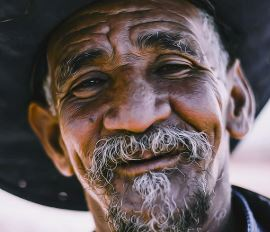

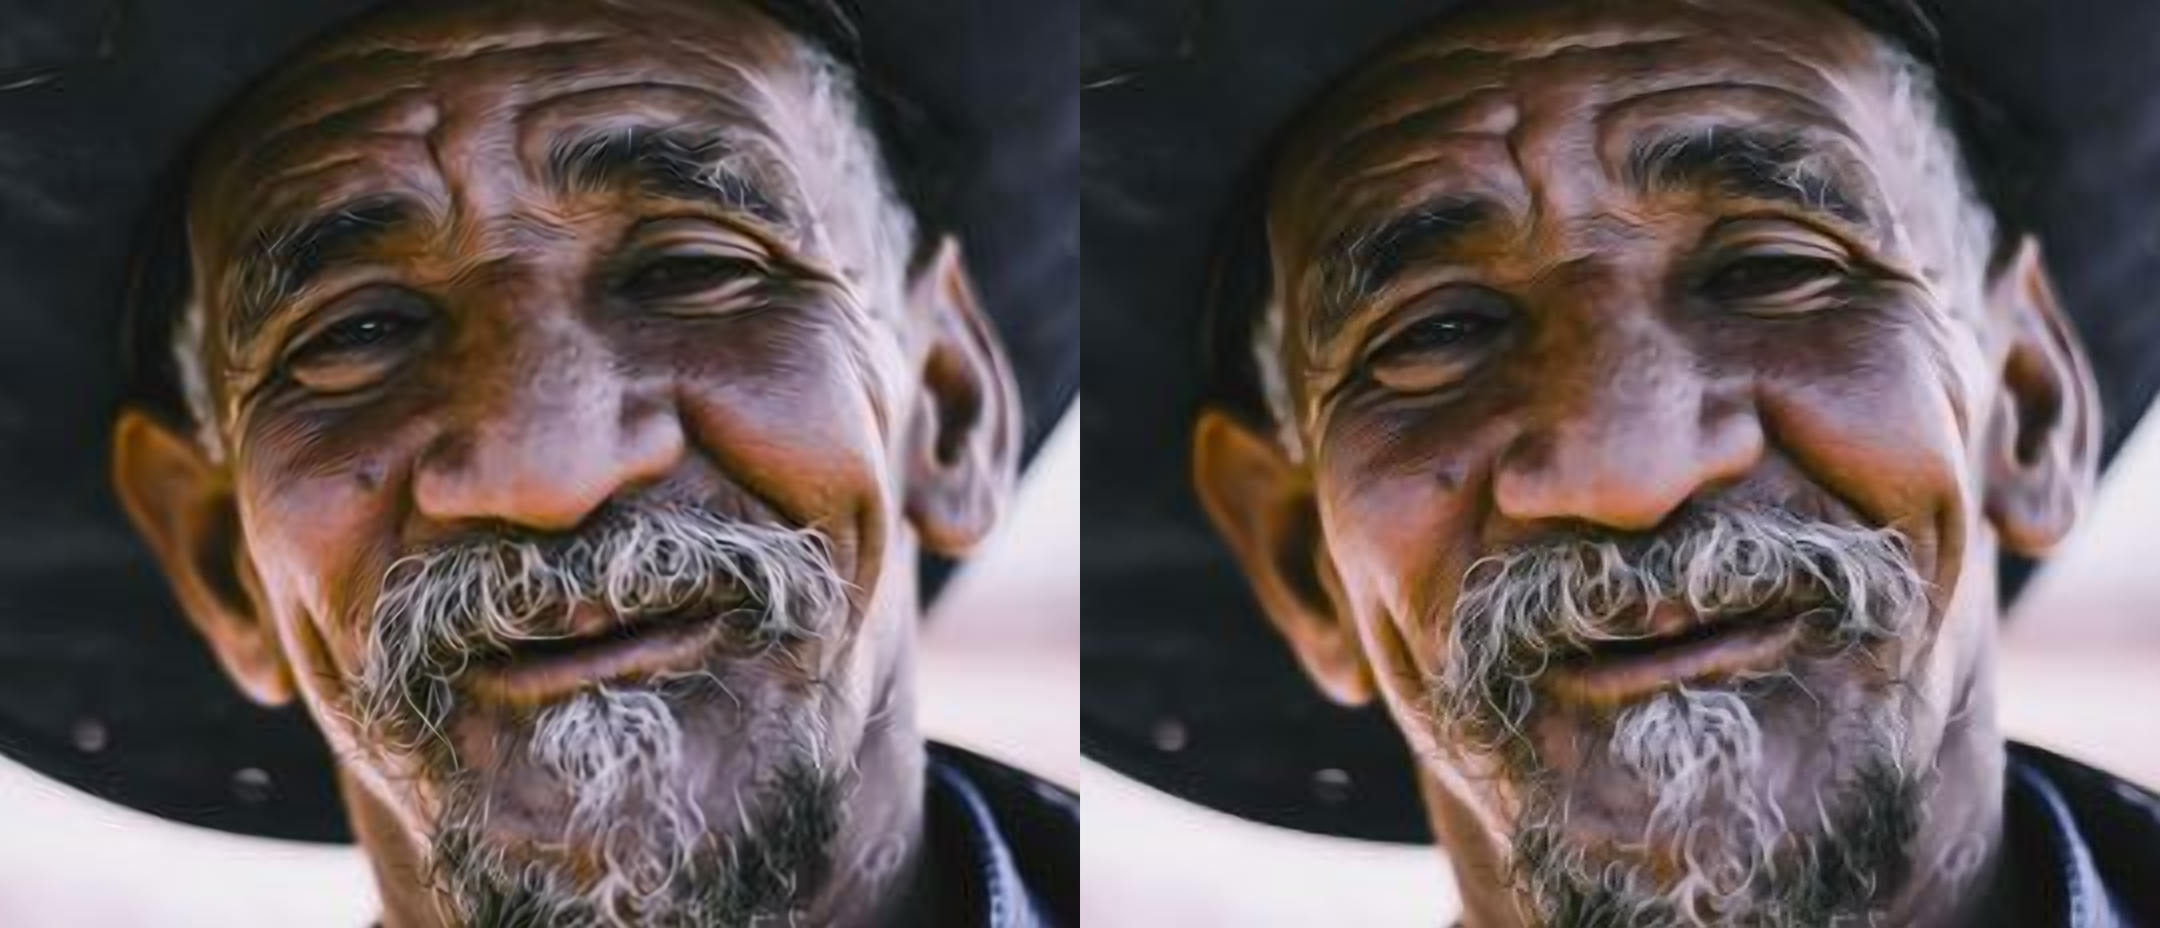

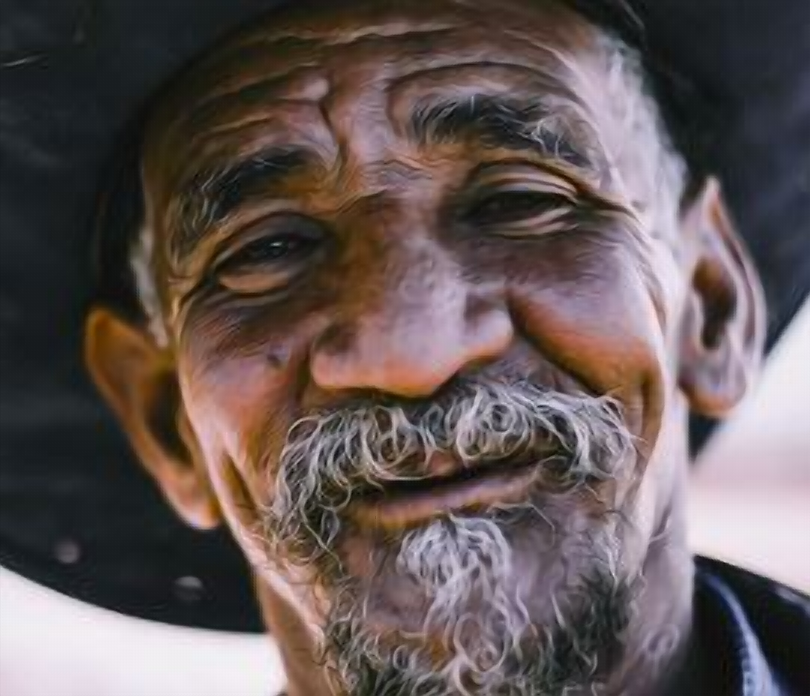

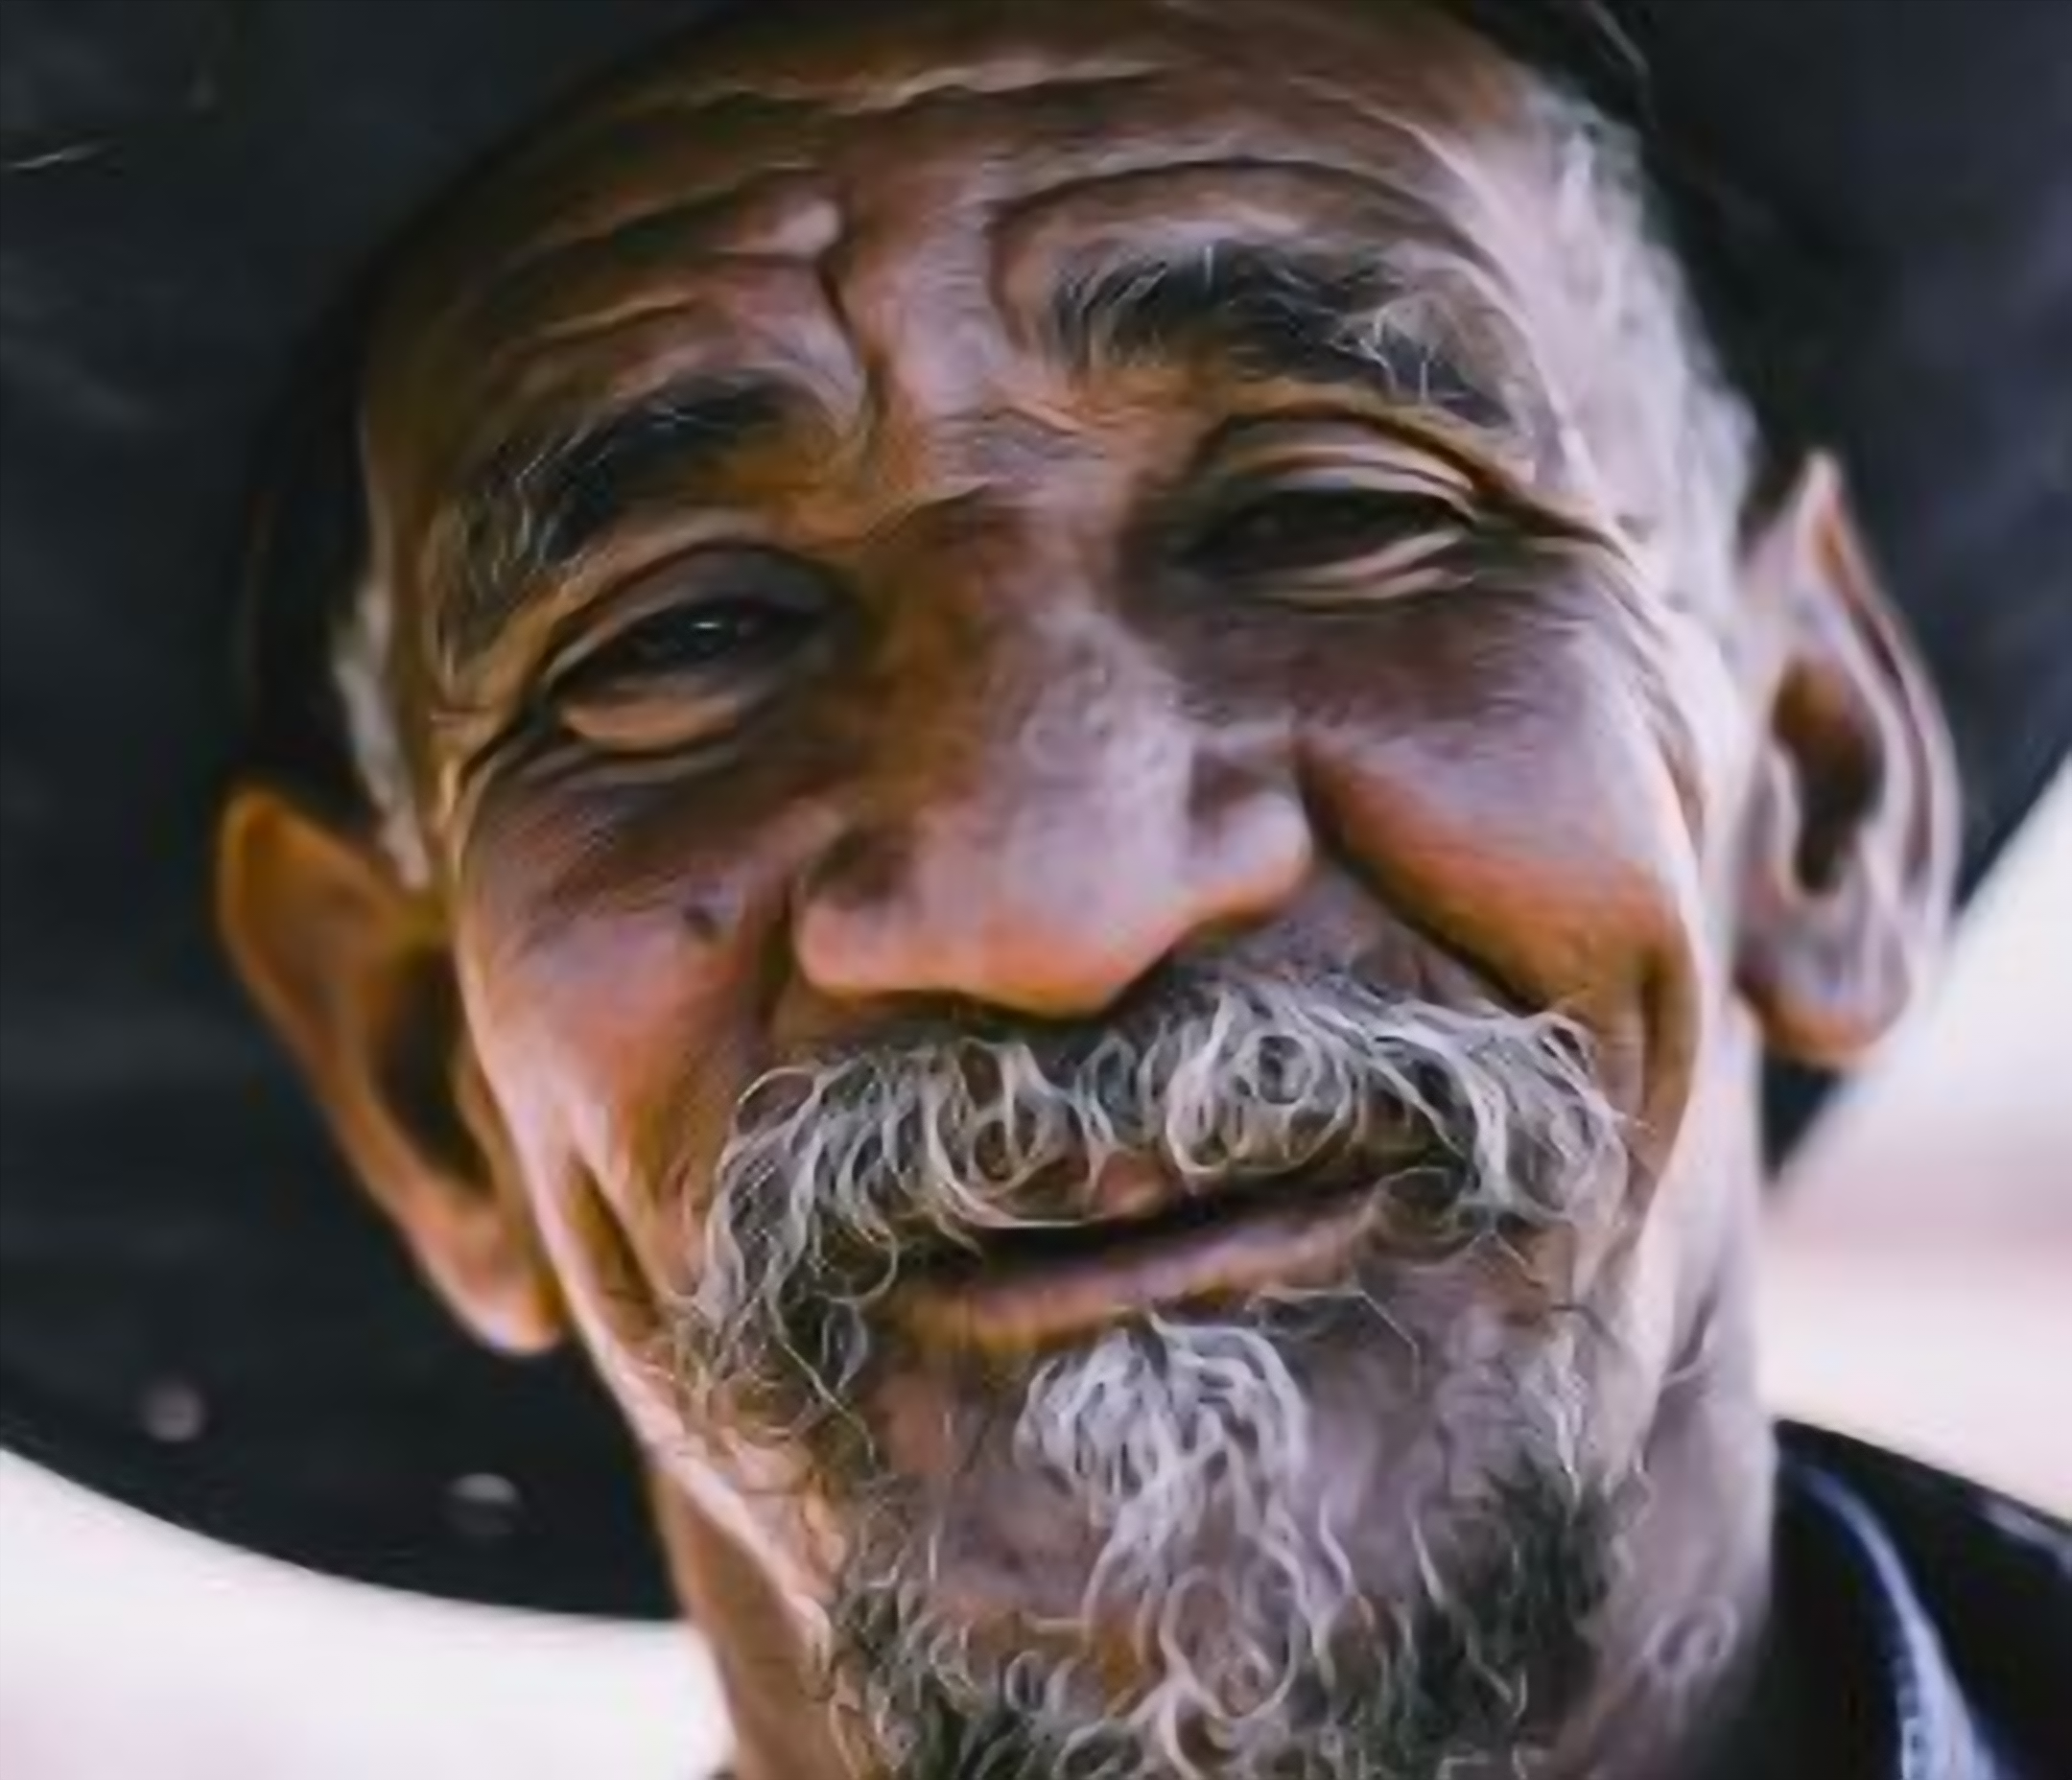

In [151]:

imagens = np.hstack((edsr, espcn))
cv2_imshow(image)
cv2_imshow(imagens)
cv2_imshow(fsrcnn)
cv2_imshow(lapsrn)


# Analise dos Resultados

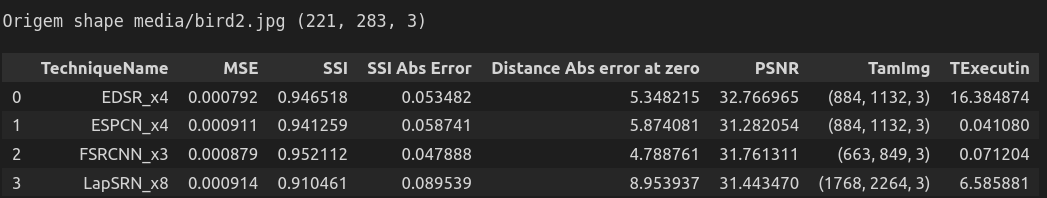

In [152]:
bird = cv2.imread("results/bird.png")
butte = cv2.imread("results/butterfy.png")
fman = cv2.imread("results/fman.png")
imgTeste = cv2.imread("results/imgTeste.png")
manh = cv2.imread("results/manh.png")
nature = cv2.imread("results/nature.png")
road = cv2.imread("results/road.png")
errorVStechnique = cv2.imread("results/Error Absolue vs. Technique.png")
timeVStechnique = cv2.imread("results/Time vs. Technique.png")

cv2_imshow(bird)


1. "Bird" image result table

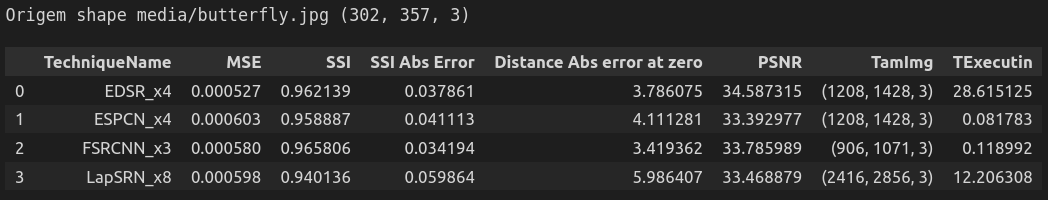

In [153]:
cv2_imshow(butte)

2. "butterfly" image result table

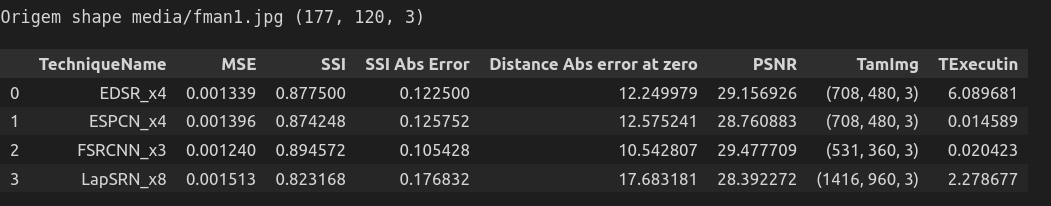

In [154]:
cv2_imshow(fman)

3. "fman" image result table

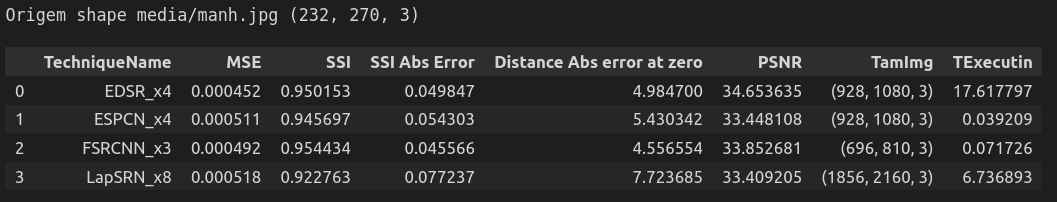

In [155]:
cv2_imshow(manh)

4. "manh" image result table

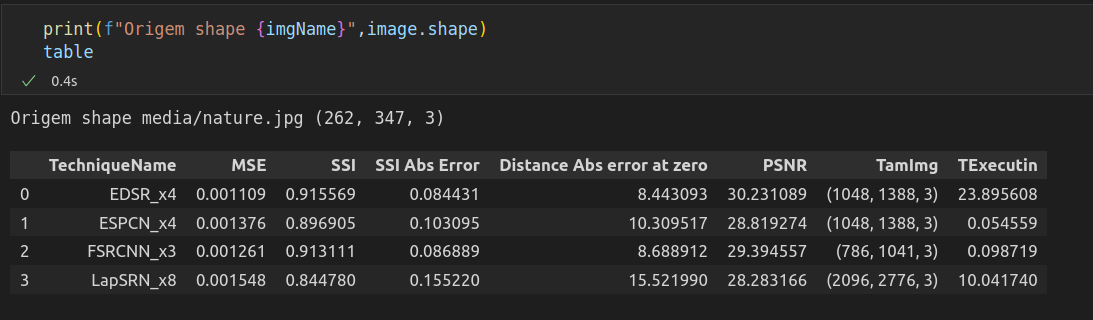

In [156]:
cv2_imshow(nature)

5. "nature" image result table

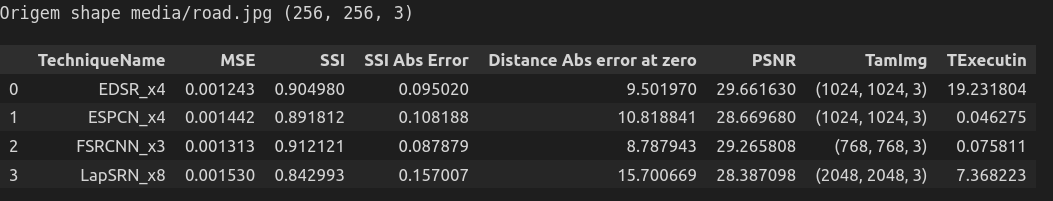

In [157]:
cv2_imshow(road)

6. "road" image result table

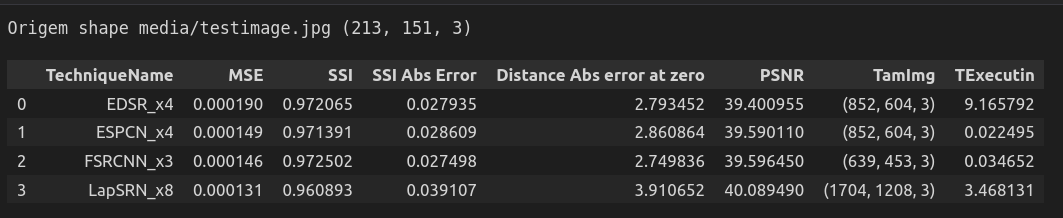

In [158]:
cv2_imshow(imgTeste)

7. "testImage" image result table

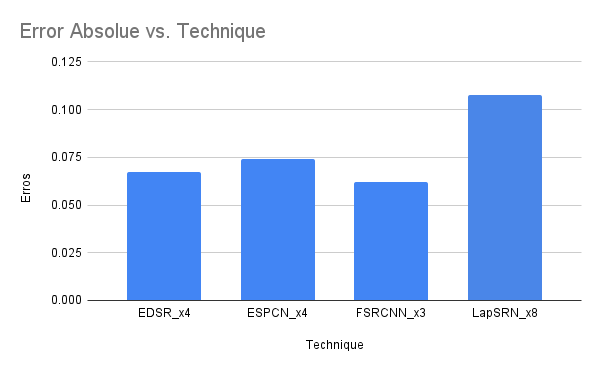

In [159]:
cv2_imshow(errorVStechnique)

It can be see that Laplacian Pyramid Super-Resolution Network (LapSRN) had the highest absulute error among the analyzed imagens.

And that the Super-Resolution Convolutional Neural Network (FSRCNN_x3) had the lowest absolute error among the techniques.

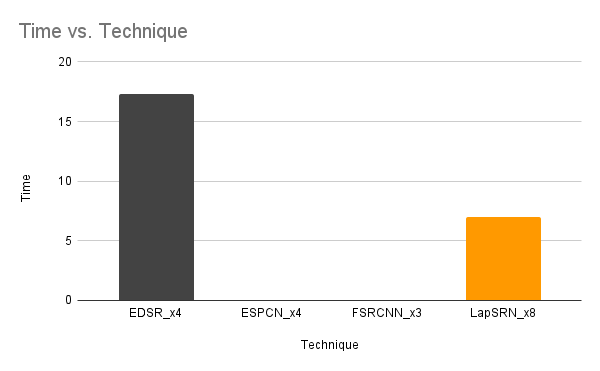

In [160]:
cv2_imshow(timeVStechnique)

And in terms of execution time, Enhanced Deep Residual Networks for Single Image Super-Resolution had the highest procesing time, followed by  LapSRN_x8.

# Conclusion


Of the studied techniques, the one that had the best result was the FSRCNN, both in absulute error and in processing time.  


This is also producing the imagens with the lowest resolutions.
